<a href="https://colab.research.google.com/github/farid-hamid/FinalYearProjectFH/blob/main/Multi_Class_Text_Classifier_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
import seaborn as sns

In [2]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Labelled Data 1.xlsx')

In [3]:
df.head()

,Unnamed: 0.1,Unnamed: 0,subReddit,Date,Datetime,Title,Body Text,Top Comment,Top Comment Reply 1,Top Comment Reply 2,Top Comment Reply 3,Top Comment Reply 4,Discussion,Topic
0,0,0,diabetes_t2,05/12/2023,05/12/2023 23:25,cheapest way to get a cgm without insurance?,well after being told my insurance would cover...,yep i’m in the same boat. my local pharmacy ch...,it's comparable to strips. i go through roughl...,NaN,NaN,NaN,cheapest way get cgm without insurance well ...,Alarm System Issues
1,1,1,diabetes_t2,20/12/2023,20/12/2023 05:13,libre 3 doesn’t stick,i’ve used the libre 3 for 3 months off and on....,"i don’t usually have this issue, but sometimes...",NaN,NaN,NaN,NaN,libre doesn’ stick ’ used the libre for mon...,Noise or Miscellaneous
2,2,2,diabetes_t2,23/12/2023,23/12/2023 23:16,frustrated with libre 3,i just got off the phone with customer support...,the first twelve hours of readings are always ...,NaN,NaN,NaN,NaN,frustrated with libre just got off the phone...,Alarm System Issues
3,3,3,diabetes_t2,23/12/2023,23/12/2023 02:32,libre 3 graphs 3 weeks in,the first graph was my first full day with my ...,i had numbers like yours when i started the li...,thank you! you as well. i had no clue that i e...,NaN,NaN,NaN,libre graphs weeks the first graph was fir...,Alarm System Issues
4,4,4,diabetes_t2,07/12/2023,07/12/2023 16:34,confused by gmi on libre 3,i'm finding myself confused by the gmi measure...,here's more than you ever wanted to know about...,thank you! that is very informative and just t...,NaN,NaN,NaN,confused gmi libre finding myself confused...,Glucose Level Monitoring


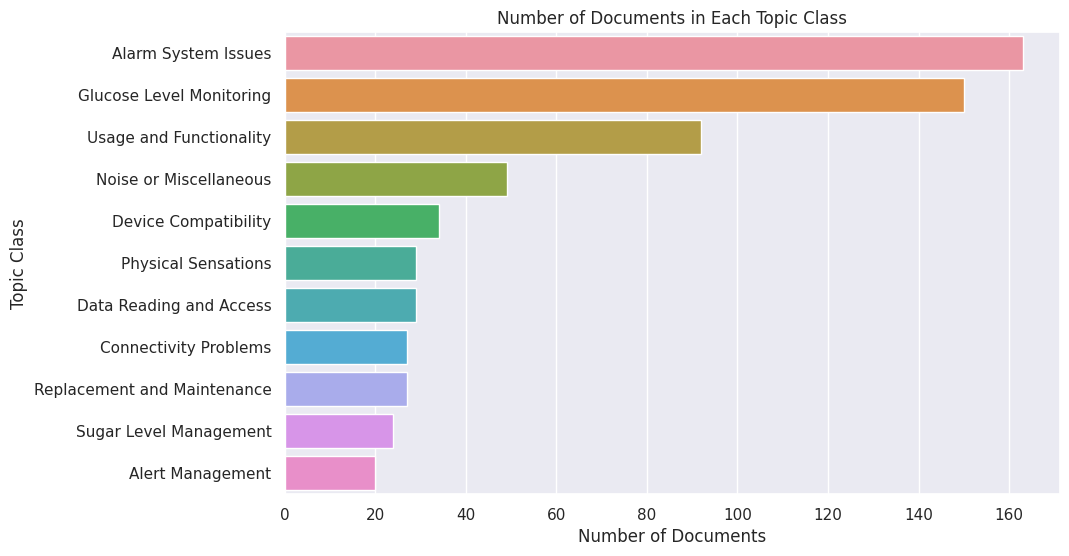

In [4]:
topic_counts = df['Topic'].value_counts()

# Create a count plot
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
sns.countplot(y='Topic', data=df, order = topic_counts.index)

# Labeling the plot
plt.title('Number of Documents in Each Topic Class')
plt.xlabel('Number of Documents')
plt.ylabel('Topic Class')

# Show the plot
plt.show()

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

In [15]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 3), stop_words='english')

features = tfidf.fit_transform(df.Discussion).toarray()
labels = df.Topic
features.shape

(644, 1197)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df['Discussion'], df['Topic'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [25]:
classifiers = [
    RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(classifiers)))
entries = []
for classifier in classifiers:
  model_name = classifier.__class__.__name__
  accuracies = cross_val_score(classifier, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [26]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.325581
1,RandomForestClassifier,1,0.387597
2,RandomForestClassifier,2,0.410853
3,RandomForestClassifier,3,0.472868
4,RandomForestClassifier,4,0.414062
5,LinearSVC,0,0.565891
6,LinearSVC,1,0.658915
7,LinearSVC,2,0.558140
8,LinearSVC,3,0.558140
9,LinearSVC,4,0.562500


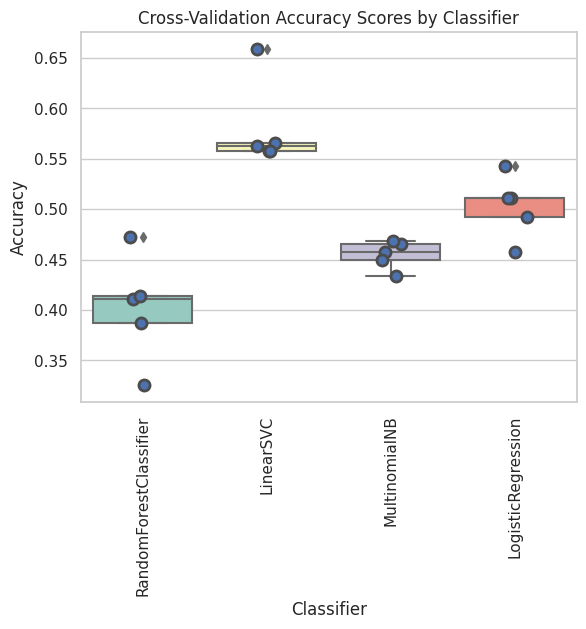

In [27]:
sns.set(style="whitegrid")

# Create a boxplot
ax = sns.boxplot(x='model_name', y='accuracy', data=cv_df, palette="Set3")

# Overlay a stripplot to show the individual observations
sns.stripplot(x='model_name', y='accuracy', data=cv_df,
              size=8, jitter=True, edgecolor="gray", linewidth=2)

# Improve the aesthetics
plt.xticks(rotation=90)  # Rotate model names for better readability if needed
plt.title('Cross-Validation Accuracy Scores by Classifier')
plt.ylabel('Accuracy')
plt.xlabel('Classifier')

plt.show()

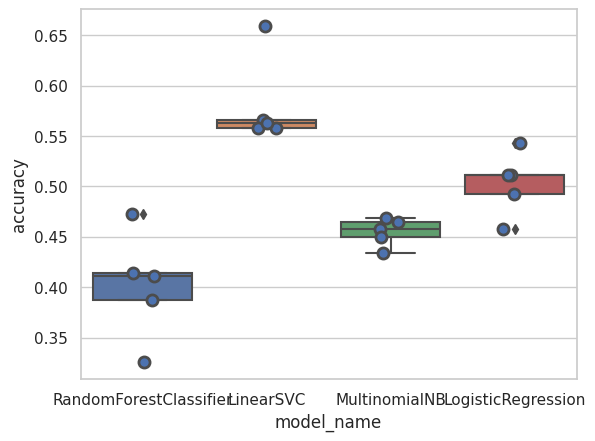

In [28]:
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df,
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [29]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.580717
LogisticRegression        0.503089
MultinomialNB             0.454990
RandomForestClassifier    0.402192
Name: accuracy, dtype: float64

In [ ]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()